How to run a star cluster simulation
====================

More realistic star clusters have stars that move and evolve in time.
The movement of stars is caused by their mutual gravity, which we will take care of by means of integrating the equations of motion under Newtonian forces. This is realized using, what we call, and N-body code. Stellar evolution influences the gravitational dynamics by altering the mass of the N-body particles. It is taken care of by means of a parametrized stellar evolution code.

For reference you can read chapter 4 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

With this tutorial you will learn
- how to generate inital conditions (mass-function, Plummer model)
- to initialize gravitational N-body codes and parametrized stellar evolution codes
- channels and intra-code data transfer
- plotting results

In [7]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from amuse.units import units
from amuse.community.ph4.interface import ph4
from amuse.community.seba.interface import SeBa
from amuse.ext.LagrangianRadii import LagrangianRadii
from amuse.lab import new_powerlaw_mass_distribution
from amuse.units import nbody_system
from amuse.ic.plummer import new_plummer_model
numpy.random.seed(63)

n_stars = 100
alpha_IMF = -2.35

m_stars = new_powerlaw_mass_distribution(n_stars, 
                                         10.0|units.MSun, 
                                         100.0|units.MSun, 
                                         alpha_IMF)

r_cluster = 1.0 | units.parsec
converter=nbody_system.nbody_to_si(m_stars.sum(), r_cluster)
stars=new_plummer_model(n_stars, convert_nbody=converter)

stars.mass = m_stars
stars.scale_to_standard(converter)

Let's start by generating the initial conditions.
This includes a mass function (for which we adopt the Salpeter power-law), and a Plummer sphere for the spatial distribution. After assigning the masses to the stars in the Plummer sphere, we scale the entire system to virial equilibrium.

In [2]:
r_cluster = 1.0 | units.parsec
from amuse.units import nbody_system
converter=nbody_system.nbody_to_si(m_stars.sum(), r_cluster)
from amuse.ic.plummer import new_plummer_model
stars=new_plummer_model(n_stars, convert_nbody=converter)
stars.mass = m_stars
stars.scale_to_standard(converter)

Let's check if this is what we expected.

In [8]:
def plot_snapshot(bodies):
    v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()
    s = bodies.mass.value_in(units.MSun)
    fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(11, 3))
    ax1.scatter(bodies.temperature.value_in(units.K),
                bodies.luminosity.value_in(units.LSun), 
                c=v.value_in(units.kms),
                s=s)
    ax1.set_xlim(6.e+4, 20000)
    ax1.set_ylim(1.e+3, 1.e+7)
    ax1.loglog()
    ax1.set_xlabel("T [K]")
    ax1.set_ylabel("L [$L_\odot$]")
    ax2.scatter(bodies.x.value_in(units.pc), 
                bodies.y.value_in(units.pc), 
                c=v.value_in(units.kms), 
                s=s)
    pyplot.gca().set_aspect('equal', adjustable='box')
    ax2.set_xlabel("x [pc]")
    ax2.set_ylabel("y [pc]")
    ax2.set_xlim(-5, 5)
    ax2.set_ylim(-5, 5)
    pyplot.show()


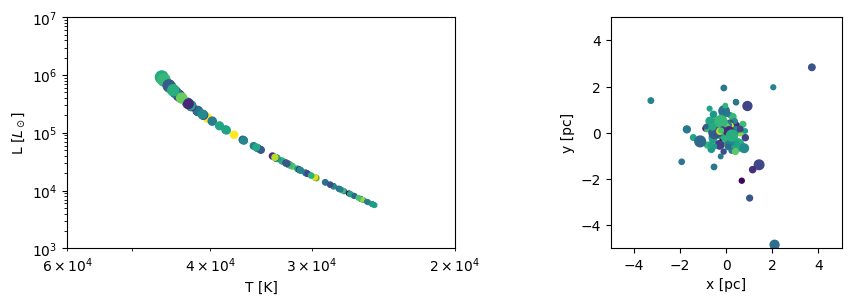

In [4]:
from amuse.community.ph4.interface import ph4
from amuse.community.seba.interface import SeBa
from amuse.ext.LagrangianRadii import LagrangianRadii

stellar = SeBa()
stellar.particles.add_particles(stars)

gravity = ph4(converter)
gravity.particles.add_particles(stars)
ch_s2g = stellar.particles.new_channel_to(gravity.particles)
ch_g2l = gravity.particles.new_channel_to(stars)
ch_s2l = stellar.particles.new_channel_to(stars)
ch_s2l.copy()

plot_snapshot(stars)

Now let's run the code. Why is the coupling timescale between gravity and stellar evolution chosen the way it is?

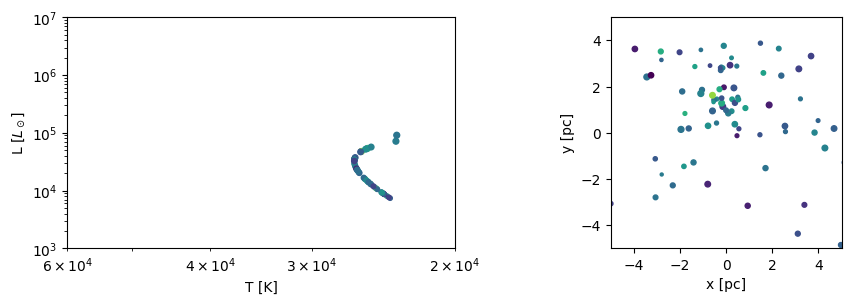

In [5]:
end_time = 10 | units.Myr
model_time = 0 | units.Myr

time = [] | units.Myr
radius = [] | units.pc

while(model_time<end_time):
    dt = stellar.particles.time_step.min()
    model_time += dt
    stellar.evolve_model(model_time)
    ch_s2g.copy()
    ch_s2l.copy()
    gravity.evolve_model(model_time)
    ch_g2l.copy()
    time.append(stellar.model_time.in_(units.Myr))
    radius.append(stars.virial_radius().in_(units.pc))
    """
    print("Evolved to t=", stellar.model_time.in_(units.Myr), 
          gravity.model_time.in_(units.Myr),
         "mass=", stars.mass.sum().in_(units.MSun), 
          "rvir=", stars.virial_radius().in_(units.pc))
    
    
plot_snapshot(stars)
stellar.stop()
gravity.stop()

In [10]:
n_stars = 100
alpha_IMF = -2.35

m_stars = new_powerlaw_mass_distribution(n_stars, 
                                     10.0|units.MSun, 
                                     100.0|units.MSun, 
                                     alpha_IMF)

In [23]:
def evolve(starevolve=True, eventdriven=True):
    end_time = 10 | units.Myr
    model_time = 0 | units.Myr
    



    stellar = SeBa()
    stellar.particles.add_particles(stars)

    gravity = ph4(converter)
    gravity.particles.add_particles(stars)
    ch_s2g = stellar.particles.new_channel_to(gravity.particles)
    ch_g2l = gravity.particles.new_channel_to(stars)
    ch_s2l = stellar.particles.new_channel_to(stars)
    ch_s2l.copy()
    
    time = [] | units.Myr
    radius = [] | units.pc
    E_kin_stars = [] | units.J
    #E_kin_stellar = [] | units.J
    E_pot_stars = [] | units.J
    #E_pot_stellar = [] | units.J

    if eventdriven==True:

        while(model_time<end_time):
            dt = stellar.particles.time_step.min()
            model_time += dt
            if starevolve==True:
                stellar.evolve_model(model_time)
            ch_s2g.copy()
            ch_s2l.copy()
            gravity.evolve_model(model_time)
            ch_g2l.copy()
            time.append(stellar.model_time.in_(units.Myr))
            radius.append(stars.virial_radius().in_(units.pc))
            E_kin_stars.append(stars.kinetic_energy().in_(units.J))
            #E_kin_stellar.append(stellar.kinetic_energy().in_(units.J))
            E_pot_stars.append(stars.potential_energy().in_(units.J))
            #E_pot_stellar.append(stellar.potential_energy().in_(units.J))
    
            """
            print("Evolved to t=", stellar.model_time.in_(units.Myr), 
                  gravity.model_time.in_(units.Myr),
                 "mass=", stars.mass.sum().in_(units.MSun), 
                  "rvir=", stars.virial_radius().in_(units.pc))
            """
    else:
        while(model_time<end_time):
            
            
            if model_time.number%1 < 0.5:
                dt = stellar.particles.time_step.min()
                stellar.evolve_model(model_time)
            else:
                gravity.evolve_model(model_time)
            model_time += dt
            ch_s2g.copy()
            ch_s2l.copy()
            print("kaas")
            
            ch_g2l.copy()
            time.append(stellar.model_time.in_(units.Myr))
            radius.append(stars.virial_radius().in_(units.pc))
            E_kin_stars.append(stars.kinetic_energy().in_(units.J))
            #E_kin_stellar.append(stellar.kinetic_energy().in_(units.J))
            E_pot_stars.append(stars.potential_energy().in_(units.J))
            #E_pot_stellar.append(stellar.potential_energy().in_(units.J))
    
            """
            print("Evolved to t=", stellar.model_time.in_(units.Myr), 
                  gravity.model_time.in_(units.Myr),
                 "mass=", stars.mass.sum().in_(units.MSun), 
                  "rvir=", stars.virial_radius().in_(units.pc))
            """
    stellar.stop()
    gravity.stop()
    return time, radius, stars, E_kin_stars, E_pot_stars

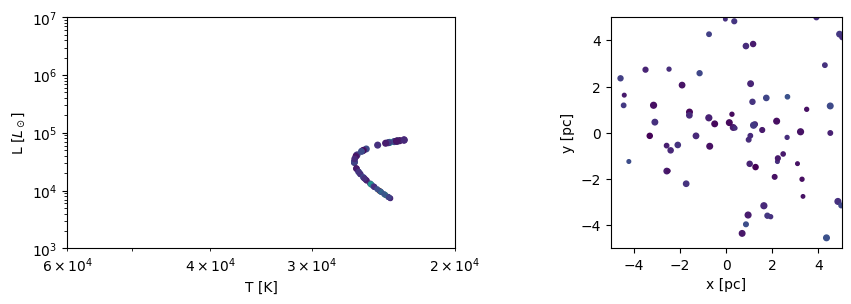

In [10]:
time_true, radius_true, stars_true, E_kin_stars_true, E_pot_stars_true = evolve()
plot_snapshot(stars_true)

You have performed a small experiment in which a population of stars was evolved from zero-age to an age of 10 Myr.
The stars were selected randomly from a Salpeter mass function, and distributed in a virialized Plummer sphere with a characteristic (Plummer) radius of 1 pc.

Assignments and questions:
---------------

### Question 1:
You have plotted the Hertzsprung-Russel diagram and the x-y projection of the cluster before and after the simulation. Describe the differences.

### Assignment 1:
Rerun the calculation, but store the time and the virial radius in arrays. Make a plot of the virial radius as a function of time.

### Question 2:
Why is the cluster expanding?

### Question 3:
Why does it take a while before the cluster starts expanding?

### Question 4:
The virial radius does not expand monotonously. Why is that?

### Assignment 2:
Rerun the calculation without stellar evolution and quantify the difference in which the cluster expands with and without taking stellar evolution into account. 
When rerunning, make sure that you are using the same initial random seed for generating the initial mass function as well as for assigning the stellar positions and velocities.

Can you explain explain the difference between the simulation with- and the one without stellar evolution?

### Question 5:
In a previous assignment you have been checking binary formation.
What will happen here if you would continue the run until the first binary forms?

### Assignment 6:
Add diagnostic checking for energy conservation to the code.
Make sure to check the energy conservation for stellar evolution and stellar dynamics separately.

### Question 6:
Make a plot of the total, the potential and the kinetic energy of the N-body system as a function of time.

To what degree is the total energy conserved?
Is the amount of energy conservation sufficient to warrant a scientifically valid result, and if so, why is this the case?

### Assignment 7:
Replace the event-driven approach from the script and replace is with a simple time stepping in which you step-over from one code to the other every million years.

Now check the evolution of the virial radius and the energy conservation of the code again, and discuss the difference with the original event-driven approach.

### Question 1

The Cluster is much more spread out and the HRD has Giants in it.

### Assignment 1

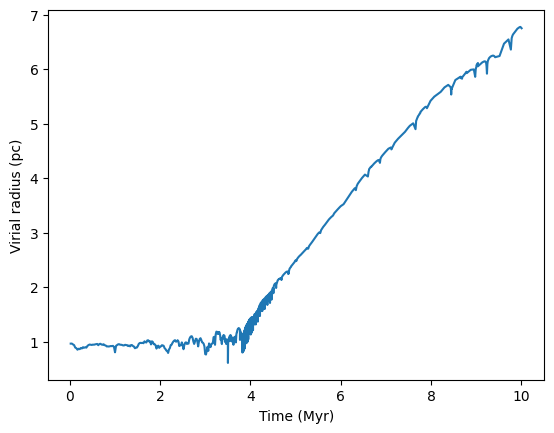

In [11]:
import matplotlib.pyplot as plt

plt.plot(time_true.value_in(units.Myr),radius_true.value_in(units.pc))
plt.xlabel("Time (Myr)")
plt.ylabel("Virial radius (pc)")
plt.show()

### Question 2

Some stars explode as Supernovae and slingshot away other stars, expanding the cluster.

### Question 3

It takes some time for the Supernovae to form!

### Question 4

Due to the IMF, there are more light mass stars than heavy mass stars, so there is no monotonous amount of Supernovae forming.

### Assignment 2

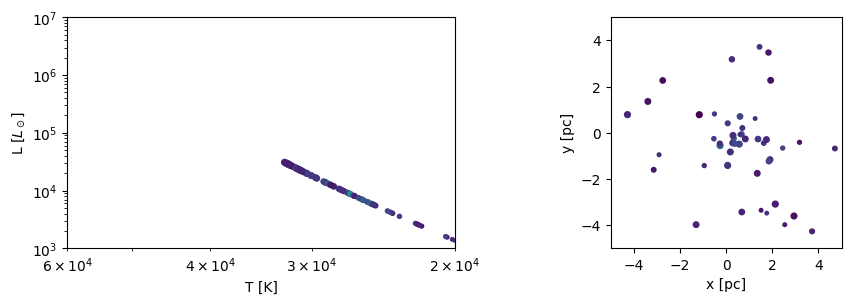

In [12]:
time_false, radius_false, stars_false, E_kin_stars_false, E_pot_stars_false = evolve(starevolve = False)
plot_snapshot(stars_false)

In [13]:
print("The difference in expansion is: The cluster without stellar evolution expands"
      , radius_false[-1]/radius_true[-1], "times the cluster with stellar evolution")

The difference in expansion is: The cluster without stellar evolution expands 1.20749970346 times the cluster with stellar evolution


### Question 5

The simulation will cut off and pretty quickly, because binary formation is easy with massive stars!

### Assignment 6

Done to function, don´t know how to track them separately...

### Question 6

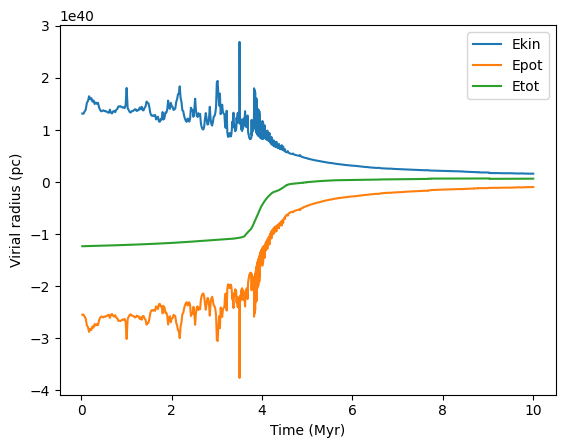

In [14]:
plt.plot(time_true.value_in(units.Myr),E_kin_stars_true.value_in(units.J), label="Ekin")
plt.plot(time_true.value_in(units.Myr),E_pot_stars_true.value_in(units.J), label="Epot")
plt.plot(time_true.value_in(units.Myr),E_kin_stars_true.value_in(units.J)+E_pot_stars_true.value_in(units.J), label="Etot")

plt.xlabel("Time (Myr)")
plt.ylabel("Virial radius (pc)")
plt.legend()
plt.show()

The total energy is conserved for the first part

### Assignment 7

In [22]:
time_step, radius_step, stars_step, E_kin_stars_step, E_pot_stars_step = evolve(eventdriven=False)

kaas


AttributeError: You tried to access attribute 'time_step' but this attribute is not defined for this set.

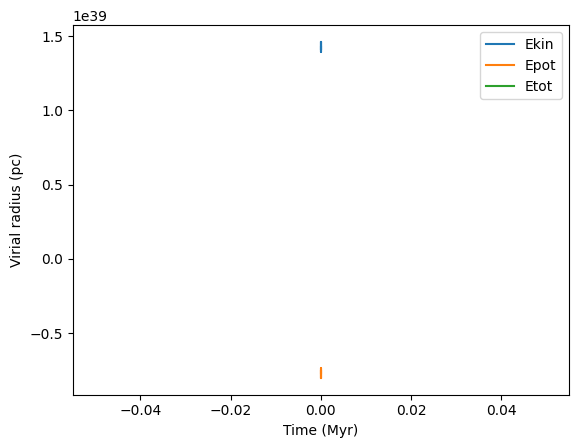

In [16]:
import matplotlib.pyplot as plt


plt.plot(time_step.value_in(units.Myr),E_kin_stars_step.value_in(units.J), label="Ekin")
plt.plot(time_step.value_in(units.Myr),E_pot_stars_step.value_in(units.J), label="Epot")
plt.plot(time_step.value_in(units.Myr),E_kin_stars_step.value_in(units.J)+E_pot_stars_step.value_in(units.J), label="Etot")

plt.xlabel("Time (Myr)")
plt.ylabel("Virial radius (pc)")
plt.legend()
plt.show()

Total energy is not conserved, so use event-driven approach according to the book as it is not working.